In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import time
 
# Define the neural network (nn) architecture 
class NeuralNetwork(nn.Module):      #Inheritance from nn-module
    def __init__(self, input_size, hidden_size, output_size):    #neural network (nn) with: i/p layer,hidden layer and o/p layer;
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  #fc: fully connected layer 1
        self.relu = nn.ReLU()  #activation function: Relu                         
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):     #Forward pass for nn
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

#Load the dataset
amazon_prime_titles = pd.read_csv("amazon_prime_titles.csv")

# Data Preprocessing

amazon_prime_titles = amazon_prime_titles.drop(['show_id', 'director', 'cast', 'country', 'date_added', 'description'], axis=1)
amazon_prime_titles = amazon_prime_titles.dropna() #drop missing values

label_encoders = {}   #encoding categorical variables
for col in amazon_prime_titles.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    amazon_prime_titles[col] = label_encoders[col].fit_transform(amazon_prime_titles[col])

#spliting featutres 'x' and target 'y'
X = amazon_prime_titles.drop(['type', 'rating'], axis=1)  
y = amazon_prime_titles['type']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standerdizing the data and converting it to tensors
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# selecting hyperparameters to understand the performance
hidden_sizes = [32, 64, 128]  
learning_rates = [0.001, 0.01, 0.1]  
num_epochs = 100

results = []

#Training
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        print(f"\nTraining model with hidden size: {hidden_size} and learning rate: {learning_rate}")
        
        # Initialize the model
        model = NeuralNetwork(input_size=X_train_tensor.shape[1], hidden_size=hidden_size, output_size=2)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Training the model
        start_time = time.time()
        for epoch in range(num_epochs):
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        end_time = time.time()
        training_time = end_time - start_time

        #Testing
        with torch.no_grad():
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
            print(f'Test Accuracy: {accuracy:.4f}')

        # results
        results.append({
            'Hidden Size': hidden_size,
            'Learning Rate': learning_rate,
            'Training Time (s)': training_time,
            'Test Accuracy': accuracy
        })

#Result table
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)



Training model with hidden size: 32 and learning rate: 0.001
Epoch [10/100], Loss: 0.6361
Epoch [20/100], Loss: 0.6310
Epoch [30/100], Loss: 0.6262
Epoch [40/100], Loss: 0.6215
Epoch [50/100], Loss: 0.6170
Epoch [60/100], Loss: 0.6126
Epoch [70/100], Loss: 0.6084
Epoch [80/100], Loss: 0.6043
Epoch [90/100], Loss: 0.6003
Epoch [100/100], Loss: 0.5965
Test Accuracy: 0.7970

Training model with hidden size: 32 and learning rate: 0.01
Epoch [10/100], Loss: 0.5360
Epoch [20/100], Loss: 0.5190
Epoch [30/100], Loss: 0.5054
Epoch [40/100], Loss: 0.4943
Epoch [50/100], Loss: 0.4849
Epoch [60/100], Loss: 0.4768
Epoch [70/100], Loss: 0.4697
Epoch [80/100], Loss: 0.4634
Epoch [90/100], Loss: 0.4576
Epoch [100/100], Loss: 0.4524
Test Accuracy: 0.7970

Training model with hidden size: 32 and learning rate: 0.1
Epoch [10/100], Loss: 0.4845
Epoch [20/100], Loss: 0.4416
Epoch [30/100], Loss: 0.4179
Epoch [40/100], Loss: 0.4021
Epoch [50/100], Loss: 0.3914
Epoch [60/100], Loss: 0.3842
Epoch [70/100], L

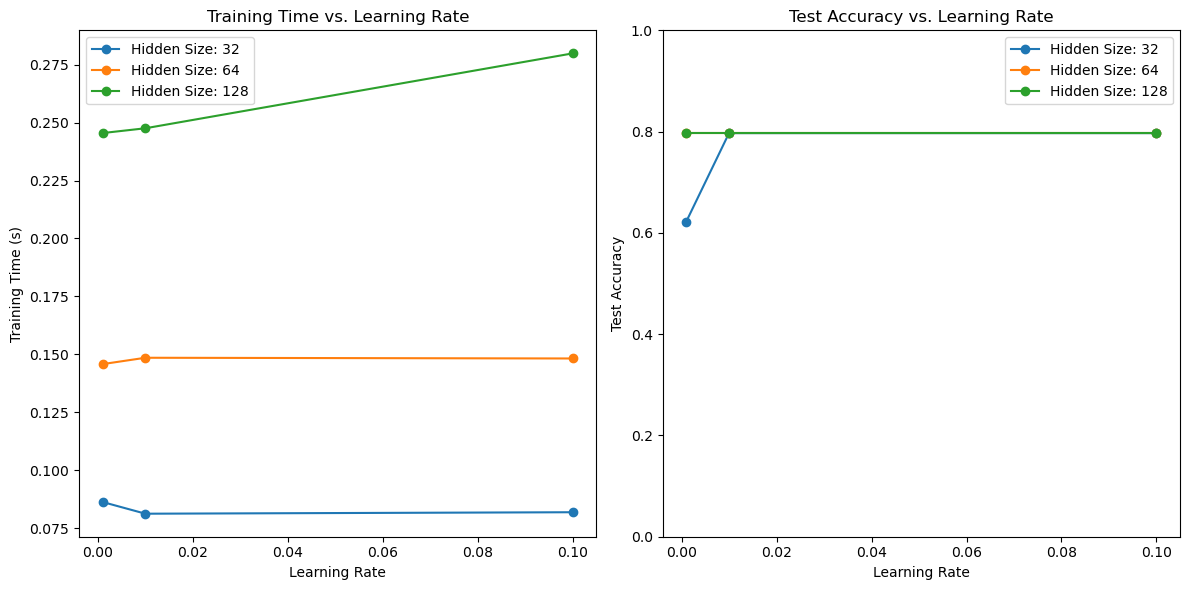

In [28]:
import matplotlib.pyplot as plt

# Separate results based on hidden size
results_32 = results_df[results_df['Hidden Size'] == 32]
results_64 = results_df[results_df['Hidden Size'] == 64]
results_128 = results_df[results_df['Hidden Size'] == 128]

# Plot training time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for hidden_size, group in results_df.groupby('Hidden Size'):
    plt.plot(group['Learning Rate'], group['Training Time (s)'], marker='o', label=f'Hidden Size: {hidden_size}')
plt.title('Training Time vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Training Time (s)')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
for hidden_size, group in results_df.groupby('Hidden Size'):
    plt.plot(group['Learning Rate'], group['Test Accuracy'], marker='o', label=f'Hidden Size: {hidden_size}')
plt.title('Test Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.tight_layout()

plt.show()


Epoch [10/100], Training Loss: 0.6159, Validation Loss: 0.6113, Training Accuracy: 0.6881, Validation Accuracy: 0.6952
Epoch [20/100], Training Loss: 0.5535, Validation Loss: 0.5544, Training Accuracy: 0.8021, Validation Accuracy: 0.7922
Epoch [30/100], Training Loss: 0.5155, Validation Loss: 0.5198, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [40/100], Training Loss: 0.4909, Validation Loss: 0.4974, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [50/100], Training Loss: 0.4739, Validation Loss: 0.4818, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [60/100], Training Loss: 0.4615, Validation Loss: 0.4704, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [70/100], Training Loss: 0.4518, Validation Loss: 0.4615, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [80/100], Training Loss: 0.4441, Validation Loss: 0.4543, Training Accuracy: 0.8062, Validation Accuracy: 0.7970
Epoch [90/100], Training Loss: 0.4376, Validatio

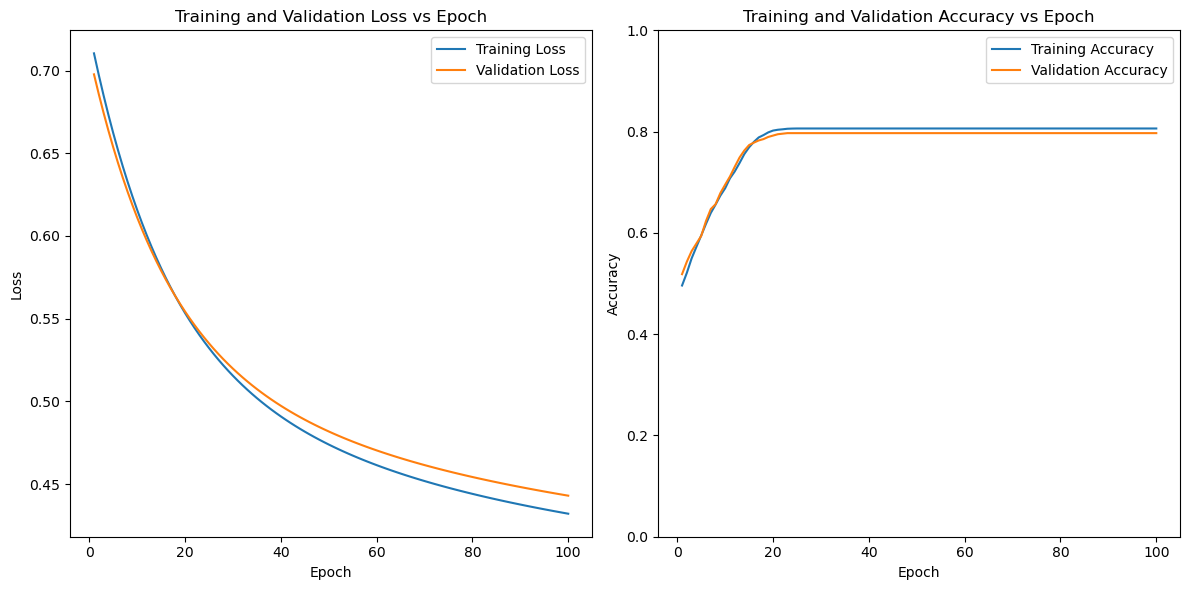

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Define the neural network (nn) architecture 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Load the dataset
amazon_prime_titles = pd.read_csv("amazon_prime_titles.csv")

# Data Preprocessing
amazon_prime_titles = amazon_prime_titles.drop(['show_id', 'director', 'cast', 'country', 'date_added', 'description'], axis=1)
amazon_prime_titles = amazon_prime_titles.dropna() # Drop missing values

label_encoders = {}   #encoding categorical variables
for col in amazon_prime_titles.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    amazon_prime_titles[col] = label_encoders[col].fit_transform(amazon_prime_titles[col])

# Split features 'X' and target 'y'
X = amazon_prime_titles.drop(['type', 'rating'], axis=1)  
y = amazon_prime_titles['type']  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # Further split into train and test

# Standardize the data and convert it to tensors
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

# Selecting hyperparameters
hidden_size = 64
learning_rate = 0.01
num_epochs = 100

# Initialize the model
model = NeuralNetwork(input_size=X_train_tensor.shape[1], hidden_size=hidden_size, output_size=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    _, predicted_train = torch.max(outputs, 1)
    train_accuracy = (predicted_train == y_train_tensor).sum().item() / len(y_train_tensor)

    # Record training loss and accuracy
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor)
        
        # Compute validation accuracy
        _, predicted_val = torch.max(outputs_val, 1)
        val_accuracy = (predicted_val == y_val_tensor).sum().item() / len(y_val_tensor)

        # Record validation loss and accuracy
        val_losses.append(loss_val.item())
        val_accuracies.append(val_accuracy)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {loss_val.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot training and validation loss vs epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

# Plot training and validation accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
